In [1]:
import copy
import time
import os
sys.path.append(os.pardir)
sys.path.append(os.path.join(os.pardir, os.pardir))
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from math import floor

from torchsummary import summary
from typing import Union
from torch.utils.data import Subset
from tqdm import tqdm
from torchvision import transforms, models
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from src.datasets import read_pickled_dataset
from src.visualization import (calculate_statistics, play_audio, plot_mfccs,
                               plot_specgram, plot_waveform,
                               visualize_random_sample)
from src.audio_utils import split_waveform, CepstralNormalization

c:\Users\David\anaconda3\envs\speaker-recon\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Librispeech Dataset (Do not run following cells if working on demo (voxCeleb+Sinisa dataset))

In [6]:
speaker_mfcc_db, mfcc_channel_db = read_pickled_dataset("librispeech-mixed") 
speaker_mfcc_db = speaker_mfcc_db.reset_index(drop=True)
# options: "librispeech-train-clean-100", "librispeech-train-other-500", "librispeech-mixed", "voxceleb1identification-4s"


 Loaded librispeech-mixed


Count number of unique speakers

In [7]:
len(np.unique(speaker_mfcc_db["speaker_id"]))

1166

Count the number of samples for each speaker_id

In [8]:
speaker_mfcc_db.groupby('speaker_id').size().sort_values()

speaker_id
449     33
421     42
680     50
689     61
974     66
      ... 
173    691
114    693
70     693
21     695
237    695
Length: 1166, dtype: int64

Text(0, 0.5, 'number of saples')

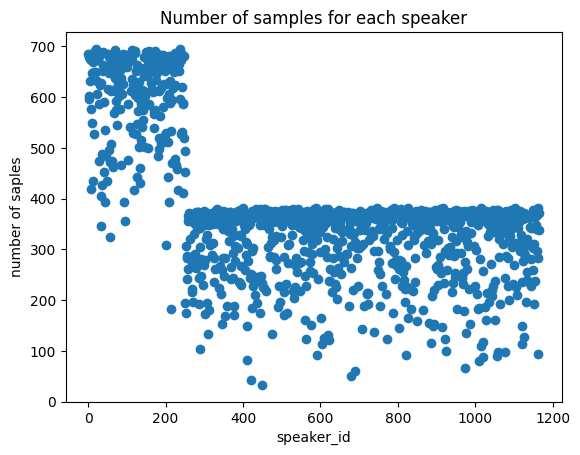

In [9]:
plt.scatter(speaker_mfcc_db.groupby('speaker_id').size().sort_values().index, speaker_mfcc_db.groupby('speaker_id').size().sort_values().values)
plt.title('Number of samples for each speaker')
plt.xlabel('speaker_id')
plt.ylabel('number of saples')

**We can decide what speaker_ids to keep in our dataset based on the number of samples**.

e.g. if we want at least 100 samples per speaker to have enough for training, validation, test (60, 20, 20)

In [6]:
min_num_samples = 100
speaker_mfcc_db_subset = speaker_mfcc_db[speaker_mfcc_db["speaker_id"].isin(speaker_mfcc_db.groupby('speaker_id').size()[speaker_mfcc_db.groupby('speaker_id').size() >= min_num_samples].index)]
number_speaker_ids = len(np.unique(speaker_mfcc_db_subset["speaker_id"]))

print(f"{number_speaker_ids} speakers in this subset, each with at least {min_num_samples} samples")

1152 speakers in this subset, each with at least 100 samples


In [7]:
mfcc_ids_subset = speaker_mfcc_db_subset["mfcc_id"].values
mfcc_channel_db_subset = mfcc_channel_db[mfcc_channel_db.index.isin(mfcc_ids_subset)]

In [8]:
speaker_mfcc_db_subset.shape, mfcc_channel_db_subset.shape

((438170, 2), (438170, 13))

## Preprocessing (Start here if working with demo)

In [2]:
def speaker_encoder(speaker_ids):
    """
    Creates a dictionary of (speaker_id, encoded_id) pairs
    """
    speaker_dict = {}
    for i, speaker_id in enumerate(speaker_ids):
        speaker_dict[speaker_id] = i
    return speaker_dict

In [3]:
class MFCCData(Dataset):
    def __init__(self, speaker_mfcc_db, mfcc_channel_db, transform=None):
        """
        Creates a dataset of spectrograms from a dataset of waveforms
        
        Inputs
        ------
        speaker_mfcc_db : pd.DataFrame
            dataframe of (index, speaker_id, mfcc_id)
            
        mfcc_channel_db : pd.DataFrame
            dataframe of (mfcc_id, channel_1, channel_2, ...)
            
        transform : optional 
            transformations to perform on the MFCCs
        """
        self.speaker_mfcc_db = speaker_mfcc_db
        self.mfcc_channel_db = mfcc_channel_db        
        self.transform = transform
            
    def __len__(self):
        return len(self.speaker_mfcc_db)

    def __getitem__(self, idx):
        speaker_id = self.speaker_mfcc_db.iloc[idx]['speaker_id']
        mfcc_id = self.speaker_mfcc_db.iloc[idx]['mfcc_id']
        
        mfcc = []
        for i, col in enumerate(self.mfcc_channel_db.columns):
            mfcc_channel_i = self.mfcc_channel_db.loc[mfcc_id, f'channel_{i}']
            mfcc.append(mfcc_channel_i)
            
        mfcc = np.asarray(mfcc)
        mfcc = mfcc.reshape(len(self.mfcc_channel_db.columns), -1)
        
        if self.transform:
            mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1])
            mfcc = np.transpose(mfcc, [1, 2, 0])
            mfcc = self.transform(mfcc)
            
        else:
            mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1])
            
        speaker_id = torch.tensor(speaker_id) 
        mfcc = torch.tensor(mfcc) 
            
        if torch.cuda.is_available():
            speaker_id = speaker_id.to('cuda')
            mfcc = mfcc.to('cuda')
            
        return mfcc, speaker_id

In [4]:
def split_train_test_val(speaker_mfcc_db, train_pct, val_pct, 
                         test_pct):
    """
    Splits the dataset into train, validation, and test. This function returns the indices of the dataframe corresponding
    to each set
    """
    train_ids = []
    val_ids = []
    test_ids = []
    
    for speaker_id in np.unique(speaker_mfcc_db["speaker_id"].values):
        mfcc_ids = speaker_mfcc_db[speaker_mfcc_db["speaker_id"]==speaker_id]["mfcc_id"].sample(frac=1).tolist()
        len_ids = len(mfcc_ids)
        
        train_ids.extend(mfcc_ids[:floor(len_ids * train_pct)])
        val_ids.extend(mfcc_ids[floor(len_ids * train_pct):floor(len_ids * (train_pct + val_pct))])
        test_ids.extend(mfcc_ids[floor(len_ids * (train_pct + val_pct)):])
    
    return train_ids, val_ids, test_ids

In [5]:
def get_datasets(speaker_mfcc_db, mfcc_channel_db, speaker_dict, window_size, sample_rate , train_pct , 
                 val_pct , test_pct , number_spectral_coefficients , cepstral_normalize , 
                 transform=None):
    """
    Wrapper around other functions to create datasets
    
    Inputs
    -----
    
    speaker_dict : dict
        dictionary of {'speaker_id':encoded_id} pairs          

    window_size : int
        window size to be used to consistently split waveforms

    sample_rate : int
        sample rate in kHz

    train_pct : float
        train percentage
    
    val_pct : float
        validation percentage

    test_pct : float
        Test percentage

    number_spectral_coefficients : int
        number of spectral coefficients to keep for the MFCC calculation
        
    normalize : bool
        whether to apply cepstral normalization
        
    transform : 
        a custom transformation to apply to the dataset
        
    Returns
    -------
    
    mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test
    
    """
    speaker_mfcc_db["speaker_id"] = speaker_mfcc_db["speaker_id"].replace(speaker_dict)
    
    # mfcc_channel_db = mfcc_channel_db.reset_index(names="speaker_id")
    # mfcc_channel_db["speaker_id"] = mfcc_channel_db["speaker_id"].replace(speaker_dict)
    # mfcc_channel_db.set_index('speaker_id', inplace=True)
    
    train_ids, val_ids, test_ids = split_train_test_val(speaker_mfcc_db, train_pct, val_pct, test_pct)
    
    # speaker_mfcc_db_train = speaker_mfcc_db.loc[train_ids]
    # speaker_mfcc_db_val = speaker_mfcc_db.loc[val_ids]
    # speaker_mfcc_db_test = speaker_mfcc_db.loc[test_ids]
    
    speaker_mfcc_db_train = speaker_mfcc_db[speaker_mfcc_db["mfcc_id"].isin(train_ids)]
    speaker_mfcc_db_val = speaker_mfcc_db[speaker_mfcc_db["mfcc_id"].isin(val_ids)]
    speaker_mfcc_db_test = speaker_mfcc_db[speaker_mfcc_db["mfcc_id"].isin(test_ids)]
    
    mfcc_channel_db_train = mfcc_channel_db.loc[speaker_mfcc_db_train["mfcc_id"].values]
    mfcc_channel_db_val = mfcc_channel_db.loc[speaker_mfcc_db_val["mfcc_id"].values]
    mfcc_channel_db_test = mfcc_channel_db.loc[speaker_mfcc_db_test["mfcc_id"].values]
    
    if cepstral_normalize:
        cepstral_normalization = CepstralNormalization(number_spectral_coefficients)
        cepstral_normalization.fit(speaker_mfcc_db_train['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_train = cepstral_normalization.transform(speaker_mfcc_db_train['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_val = cepstral_normalization.transform(speaker_mfcc_db_val['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_test = cepstral_normalization.transform(speaker_mfcc_db_test['mfcc_id'].values, mfcc_channel_db)
        mfcc_channel_db = pd.concat([normalized_mfcc_channel_db_train, normalized_mfcc_channel_db_val, normalized_mfcc_channel_db_test])
        
    mfcc_channel_db_train = mfcc_channel_db.loc[speaker_mfcc_db_train['mfcc_id'].values]
    mfcc_channel_db_val = mfcc_channel_db.loc[speaker_mfcc_db_val['mfcc_id'].values]
    mfcc_channel_db_test = mfcc_channel_db.loc[speaker_mfcc_db_test['mfcc_id'].values]
    
    mfcc_dataset_train = MFCCData(speaker_mfcc_db_train, mfcc_channel_db_train, transform=transform)
    mfcc_dataset_val = MFCCData(speaker_mfcc_db_val, mfcc_channel_db_val, transform=transform)
    mfcc_dataset_test = MFCCData(speaker_mfcc_db_test, mfcc_channel_db_test, transform=transform)

    return mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test

## Stop here if working with demo

In [14]:
# preprocessing parameters
sample_rate = 16000 # 16kHz
window_size = 4 * sample_rate # 1 second has 16000 samples, window_size is 4 seconds

batch_size = 10

train_pct = 0.60
val_pct = 0.20
test_pct = 0.20
number_spectral_coefficients = 13
cepstral_normalize = True

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(224, 224))]) 

speaker_dict = speaker_encoder(np.unique(speaker_mfcc_db['speaker_id']))


In [14]:
speaker_mfcc_db_subset.shape, mfcc_channel_db_subset.shape

((438170, 2), (438170, 13))

In [16]:
mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test = get_datasets(speaker_mfcc_db.copy(), mfcc_channel_db.copy(),
                                                speaker_dict=speaker_dict,
                                                window_size=window_size, 
                                                sample_rate=sample_rate, 
                                                train_pct=train_pct,
                                                val_pct=val_pct,
                                                test_pct=test_pct,
                                                number_spectral_coefficients=number_spectral_coefficients,
                                                cepstral_normalize=cepstral_normalize,
                                                transform=transform,
                                                )

Normalizing...


100%|██████████| 13/13 [00:45<00:00,  3.53s/it]


In [17]:
train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mfcc_dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mfcc_dataset_test, batch_size=batch_size, shuffle=False)

In [18]:
train_subset = Subset(mfcc_dataset_train, range(0, mfcc_dataset_train.__len__(), 50))
val_subset = Subset(mfcc_dataset_val, range(0, mfcc_dataset_val.__len__(), 50))

In [19]:
train_subset.__len__()

5262

In [20]:
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)

![](2022-12-01-23-55-34.png)

In [7]:
#Custom Net Class
class CustomNet(nn.Module):
    def __init__(self, num_classes: int = 1152, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            #Input size: 1 * 224 * 224 (C x H x W)
            nn.Conv2d(1, 64, kernel_size=3, stride=4, padding=2),
            #Size after: 64 * 56 * 56 
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 64 * 28 * 28
            nn.Conv2d(64, 384, kernel_size=5, padding=2),
            #Size after: 384 * 28 * 28
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 384 * 14 * 14
            nn.Conv2d(384, 128, kernel_size=3, padding=1),
            #Size after: 128 *16 * 16
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 128 * 6 * 6
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(128 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
            nn.LogSoftmax(dim = 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
subset_train_size, subset_val_size = mfcc_dataset_train.__len__(), mfcc_dataset_val.__len__()

In [28]:



# Define Optimizer and Loss Function

def train_and_validate(model, epochs=25, batch_size = 10, lr=1e-3):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0
    loss_criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(mfcc_dataset_val, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)
                
                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/subset_train_size 
        avg_train_acc = train_acc/subset_train_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/subset_val_size 
        avg_valid_acc = valid_acc/subset_val_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [26]:
subset_train_size

263065

In [27]:
output_size = len(np.unique(speaker_mfcc_db['speaker_id']))

net =  CustomNet(num_classes=output_size)

In [28]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

trained_model, history = train_and_validate(net, epochs=10, batch_size = 64, lr=1e-4)

Epoch: 1/10


C:\Users\David\AppData\Local\Temp\ipykernel_5776\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Epoch : 001, Training: Loss: 2.7241, Accuracy: 43.5812%, 
		Validation : Loss : 0.7397, Accuracy: 80.0093%, Time: 440.8508s
Epoch: 2/10
Epoch : 002, Training: Loss: 0.6044, Accuracy: 82.9548%, 
		Validation : Loss : 0.4025, Accuracy: 88.8361%, Time: 441.8106s
Epoch: 3/10
Epoch : 003, Training: Loss: 0.3399, Accuracy: 89.9637%, 
		Validation : Loss : 0.4047, Accuracy: 89.0672%, Time: 444.2392s
Epoch: 4/10
Epoch : 004, Training: Loss: 0.2364, Accuracy: 92.7554%, 
		Validation : Loss : 0.2605, Accuracy: 92.9149%, Time: 446.9260s
Epoch: 5/10
Epoch : 005, Training: Loss: 0.1812, Accuracy: 94.3254%, 
		Validation : Loss : 0.1961, Accuracy: 94.6224%, Time: 440.2298s
Epoch: 6/10
Epoch : 006, Training: Loss: 0.1451, Accuracy: 95.3719%, 
		Validation : Loss : 0.2367, Accuracy: 93.9599%, Time: 443.3254s
Epoch: 7/10
Epoch : 007, Training: Loss: 0.1225, Accuracy: 96.0975%, 
		Validation : Loss : 0.2150, Accuracy: 94.7066%, Time: 443.3344s
Epoch: 8/10
Epoch : 008, Training: Loss: 0.1055, Accuracy: 9

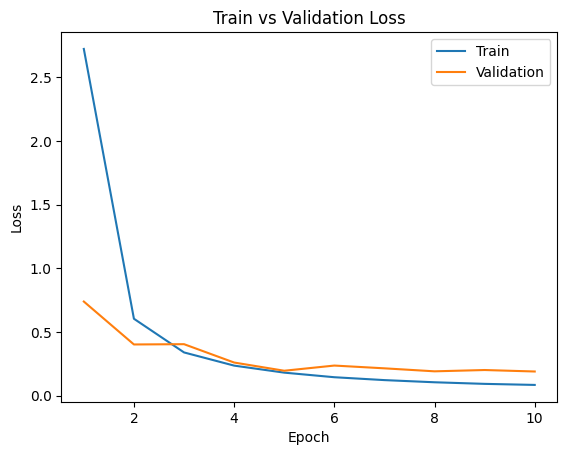

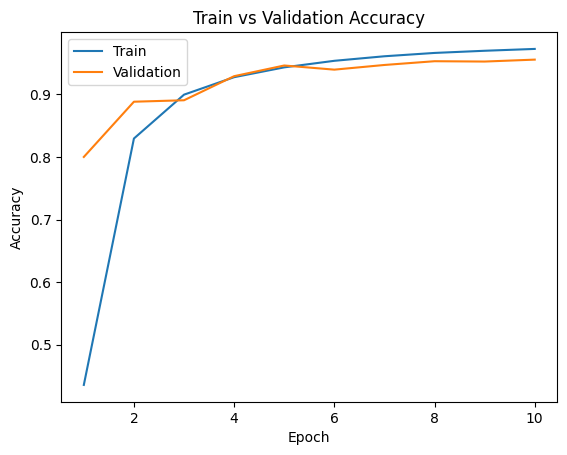

In [29]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
ep = []
i = 0
for tloss,vloss, tacc, vacc in history:
    train_acc.append(tacc)
    val_acc.append(vacc)
    train_loss.append(tloss)
    val_loss.append(vloss)
    ep.append(i)
    i += 1


n = len(train_loss) # number of epochs
plt.figure()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
# plt.show()

plt.figure()
plt.title("Train vs Validation Accuracy")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

In [29]:
def test_model(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            mfcc, speakers = data
            outputs = model(mfcc)
            _, predicted = torch.max(outputs.data, 1)
            total += speakers.size(0)
            correct += (predicted == speakers).sum().item()

    print(f'Accuracy: {100 * correct // total} %')

In [31]:
test_model(net, test_loader)

C:\Users\David\AppData\Local\Temp\ipykernel_5776\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Accuracy: 95 %


In [10]:
#Saving the trained model

path = r"F:\speaker_project\audio-speaker-recognition\notebooks\net.pth"
torch.save(net, path)



NameError: name 'net' is not defined

In [6]:
#Custom Net Class
class CustomNet(nn.Module):
    def __init__(self, num_classes: int = 1152, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            #Input size: 1 * 224 * 224 (C x H x W)
            nn.Conv2d(1, 64, kernel_size=3, stride=4, padding=2),
            #Size after: 64 * 56 * 56 
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 64 * 28 * 28
            nn.Conv2d(64, 384, kernel_size=5, padding=2),
            #Size after: 384 * 28 * 28
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 384 * 14 * 14
            nn.Conv2d(384, 128, kernel_size=3, padding=1),
            #Size after: 128 *16 * 16
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 128 * 6 * 6
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(128 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
            nn.LogSoftmax(dim = 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [7]:
'''
Load the pretrained CustomNet Model
'''
#Copy the full path of net.pth file
model = torch.load(r'F:\speaker_project\audio-speaker-recognition\notebooks\net.pth')

In [8]:
model

CustomNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(4, 4), padding=(2, 2))
    (1): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 384, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(384, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4608, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features

Transfer Learning with VoxCeleb dataset

In [9]:
def read_pickled_dataset(dataset_name : str):
    """
    Inputs
    ------
    dataset_name : str
        Name of the dataset to download. 
    
    Returns
    -------
    speaker_mfcc_db : pd.DataFrame 
        df with shape (index_id, speaker_id, mfcc_id)
    
    mfcc_channel_db : pd.DataFrame
        df with shape (mfcc_id, channel_id)

    """
    if dataset_name == "librispeech-train-clean-100":
        speaker_mfcc_db = pd.read_pickle('speaker_mfcc_db_64000_16000_13_100.pkl')
        mfcc_channel_db = pd.read_pickle('mfcc_channel_db_64000_16000_13_100.pkl')
    
    elif dataset_name == "librispeech-train-other-500":
        speaker_mfcc_db = pd.read_pickle(f'speaker_mfcc_db_64000_16000_13_500.pkl')
        mfcc_channel_db = pd.read_pickle(f'mfcc_channel_db_64000_16000_13_500.pkl')

    elif dataset_name == "voxceleb1identification-4s":
        speaker_mfcc_db = pd.read_pickle(f'speaker_mfcc_db_64000_16000_13_voxceleb_4s.pkl')
        mfcc_channel_db = pd.read_pickle(f'mfcc_channel_db_64000_16000_13_voxceleb_4s.pkl')

    elif dataset_name == "voxceleb_with_sinisa":
        speaker_mfcc_db = pd.read_pickle(f'speaker_mfcc_voxceleb_with_sinisa.pkl')
        mfcc_channel_db = pd.read_pickle(f'mfcc_channel_db_voxceleb_with_sinisa.pkl')

    elif dataset_name == "librispeech-mixed":
        speaker_mfcc_db_500 = pd.read_pickle(f'speaker_mfcc_db_64000_16000_13_500.pkl')
        mfcc_channel_db_500 = pd.read_pickle(f'mfcc_channel_db_64000_16000_13_500.pkl')

        speaker_mfcc_db_100 = pd.read_pickle('speaker_mfcc_db_64000_16000_13_100.pkl')
        mfcc_channel_db_100= pd.read_pickle('mfcc_channel_db_64000_16000_13_100.pkl')

        speaker_mfcc_db_100["mfcc_id"] = speaker_mfcc_db_100["mfcc_id"] + 400000
        mfcc_channel_db_100.index = mfcc_channel_db_100.index + 400000

        mfcc_channel_db = pd.concat([mfcc_channel_db_500, mfcc_channel_db_100])
        speaker_mfcc_db = pd.concat([speaker_mfcc_db_500, speaker_mfcc_db_100])
   

    else:
        raise ValueError(f"The dataset you passed '{dataset_name}' is not in the list of datasets")

    print(f"\n Loaded {dataset_name}")

    return speaker_mfcc_db, mfcc_channel_db

In [10]:
speaker_mfcc_db, mfcc_channel_db = read_pickled_dataset("voxceleb_with_sinisa") 
speaker_mfcc_db = speaker_mfcc_db.reset_index(drop=True)
#mfcc_channel_db = mfcc_channel_db.reset_index(drop=True)
# options: "librispeech-train-clean-100", "librispeech-train-other-500", "librispeech-mixed", "voxceleb1identification-4s", "voxceleb_with_sinisa"


 Loaded voxceleb_with_sinisa


In [11]:
speaker_mfcc_db.shape, mfcc_channel_db.shape

((230362, 2), (230362, 13))

In [12]:
mfcc_channel_db = mfcc_channel_db.reset_index(drop=True)
speaker_mfcc_db['mfcc_id'] = mfcc_channel_db.index

In [13]:
speaker_mfcc_db["mfcc_id"].duplicated().any()

False

In [14]:
# preprocessing parameters
sample_rate = 16000 # 16kHz
window_size = 4 * sample_rate # 1 second has 16000 samples, window_size is 4 seconds

batch_size = 10

train_pct = 0.60
val_pct = 0.20
test_pct = 0.20
number_spectral_coefficients = 13
cepstral_normalize = True

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(224, 224))]) 

speaker_dict = speaker_encoder(np.unique(speaker_mfcc_db['speaker_id'].values))


In [54]:
mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test = get_datasets(speaker_mfcc_db.copy(), mfcc_channel_db.copy(),
                                                speaker_dict=speaker_dict,
                                                window_size=window_size, 
                                                sample_rate=sample_rate, 
                                                train_pct=train_pct,
                                                val_pct=val_pct,
                                                test_pct=test_pct,
                                                number_spectral_coefficients=number_spectral_coefficients,
                                                cepstral_normalize=cepstral_normalize,
                                                transform=transform,
                                                )

Normalizing...


100%|██████████| 13/13 [00:24<00:00,  1.88s/it]


In [16]:
subset_train_size, subset_val_size = mfcc_dataset_train.__len__(), mfcc_dataset_val.__len__()

In [31]:
for param in model.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(2048, 1252)

model

CustomNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(4, 4), padding=(2, 2))
    (1): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 384, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(384, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4608, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features

In [32]:
subset_train_size, subset_val_size = mfcc_dataset_train.__len__(), mfcc_dataset_val.__len__()
#1252

In [55]:
train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mfcc_dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mfcc_dataset_test, batch_size=batch_size, shuffle=True)

In [20]:
speaker_dict[8888]

1251

In [36]:

net =  model

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

trained_model, history = train_and_validate(net, epochs=12, batch_size = 32, lr=1e-4)

Epoch: 1/12


C:\Users\David\AppData\Local\Temp\ipykernel_5824\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Epoch : 001, Training: Loss: 3.8310, Accuracy: 36.2377%, 
		Validation : Loss : 2.6017, Accuracy: 52.3708%, Time: 222.7289s
Epoch: 2/12
Epoch : 002, Training: Loss: 2.1073, Accuracy: 55.1573%, 
		Validation : Loss : 2.2174, Accuracy: 59.0938%, Time: 221.2566s
Epoch: 3/12
Epoch : 003, Training: Loss: 1.6570, Accuracy: 62.1181%, 
		Validation : Loss : 2.0948, Accuracy: 61.9908%, Time: 221.5474s
Epoch: 4/12
Epoch : 004, Training: Loss: 1.4098, Accuracy: 66.4072%, 
		Validation : Loss : 2.0570, Accuracy: 63.4448%, Time: 209.7317s
Epoch: 5/12
Epoch : 005, Training: Loss: 1.2361, Accuracy: 69.3367%, 
		Validation : Loss : 2.0319, Accuracy: 64.5667%, Time: 209.1147s
Epoch: 6/12
Epoch : 006, Training: Loss: 1.1082, Accuracy: 71.7863%, 
		Validation : Loss : 2.0411, Accuracy: 65.1462%, Time: 213.6651s
Epoch: 7/12
Epoch : 007, Training: Loss: 1.0218, Accuracy: 73.4094%, 
		Validation : Loss : 2.0495, Accuracy: 65.8623%, Time: 226.2184s
Epoch: 8/12
Epoch : 008, Training: Loss: 0.9448, Accuracy: 7

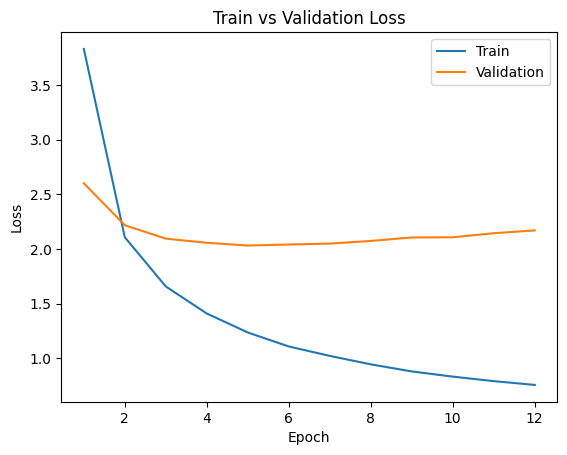

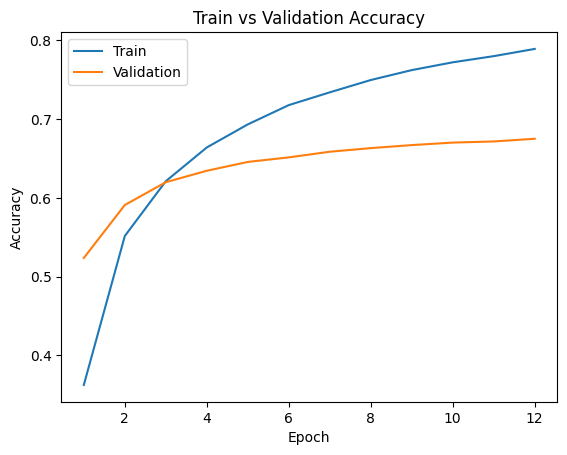

In [39]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
ep = []
i = 0
for tloss,vloss, tacc, vacc in history:
    train_acc.append(tacc)
    val_acc.append(vacc)
    train_loss.append(tloss)
    val_loss.append(vloss)
    ep.append(i)
    i += 1


n = len(train_loss) # number of epochs
plt.figure()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
# plt.show()

plt.figure()
plt.title("Train vs Validation Accuracy")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

In [40]:
test_model(model, test_loader)

C:\Users\David\AppData\Local\Temp\ipykernel_5824\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Accuracy: 67 %


In [41]:
#Saving the transfer learning model on celeb+Sinisa dataset

path = r"F:\speaker_project\audio-speaker-recognition\notebooks\transferred_model.pth"
torch.save(model, path)

## Start here again to actually work on demo

In [ ]:
#First have to call the model base structure

class CustomNet(nn.Module):
    def __init__(self, num_classes: int = 1252, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            #Input size: 1 * 224 * 224 (C x H x W)
            nn.Conv2d(1, 64, kernel_size=3, stride=4, padding=2),
            #Size after: 64 * 56 * 56 
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 64 * 28 * 28
            nn.Conv2d(64, 384, kernel_size=5, padding=2),
            #Size after: 384 * 28 * 28
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 384 * 14 * 14
            nn.Conv2d(384, 128, kernel_size=3, padding=1),
            #Size after: 128 *16 * 16
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 128 * 6 * 6
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(128 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
            nn.LogSoftmax(dim = 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [17]:
'''
Load the pretrained parameters for Model
'''
#Copy the full path of transferred_model.pth file
model = torch.load(r'F:\speaker_project\audio-speaker-recognition\notebooks\transferred_model.pth')

In [28]:
#Load the vox indexing csv file for referencing the actual name of speaker_ids
voxfile = r"F:\speaker_project\audio-speaker-recognition\notebooks\vox1_meta.csv"
vox_df = pd.read_csv(voxfile)

In [89]:
#Creating a name list with its index
name = []
for i in range(1251):

    name.append(str(vox_df.iloc[i])[64:].split('\\')[0])

In [90]:
#Checking name index
name[1250]

'Zulay_Henao'

In [104]:
#helper function to print the name of ith batch in test loader
def print_name(speakers, predicted):
    actual = []
    model_output = []
    speakers.tolist()
    predicted.tolist()
    for spk in speakers:
        actual.append(name[spk-1])
    for pred in predicted:
        model_output.append(name[pred-1])


    dict = {"Actual":actual,"Predicted":model_output}
    return pd.DataFrame(dict)
    #print("Actual Celeberity in this demo batch are:", actual)
    #print("Model predictions are:", model_output)

def get_ith_batch_result(num):
    with torch.no_grad():
        cnt = 0
        for data in test_loader:
            mfcc, speakers = data
            outputs = model(mfcc)
            _, predicted = torch.max(outputs.data, 1)
            df = print_name(speakers, predicted)
            cnt += 1
            if cnt == num:
                break
    return df

In [108]:
#get the name of actual and model predicted celeb names for batch 25 in test loader 
result = get_ith_batch_result(25)
result

C:\Users\David\AppData\Local\Temp\ipykernel_2308\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


,Actual,Predicted
0,Maya_Rudolph,Maya_Rudolph
1,Ian_Somerhalder,Ian_Somerhalder
2,Retta,Retta
3,Natascha_McElhone,Natascha_McElhone
4,Max_Irons,Max_Irons
5,Rob_Dyrdek,Rob_Dyrdek
6,Chadwick_Boseman,Chadwick_Boseman
7,Shonda_Rhimes,Shonda_Rhimes
8,Meredith_Baxter,Olivia_Munn
9,Maya_Rudolph,Maya_Rudolph
